In [31]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]= "2"
import numpy as np

launch.json used to generate epoch-wise pkls

In [32]:
# {
#     "version": "0.2.0",
#     "configurations": [
#    	 {
#    		 "name": "Run with argument",
#    		 "type": "python",
#    		 "request": "launch",
#    		 "program": "${file}",
#    		 "console": "integratedTerminal",
#    		 "cwd": "${workspaceFolder}/tools",
#    		 "env": {"CUDA_VISIBLE_DEVICES": "1"},
#    		 "args": ["--cfg_file" ,
#            		 "cfgs/kitti_models/pv_rcnn_ssl_60.yaml",
#            		 "--split",
#            		 "train_0.01_1",
#            		 "--batch_size",
#            		 "8",
#            		 "--ckpt_save_interval",
#            		 "20",
#            		 "--repeat",
#            		 "5",
#            		 "--fix_random_seed",
#            		 "--extra_tag",
#            		 "tsne_3diou_secndstage_ckpt60_snapshot_new_ulbloader",
#            		 "--dbinfos",
#            		 "kitti_dbinfos_train_0.01_1_37.pkl",
#                  "--epochs", // for repeat 5, bsz 8: to cover 3769 ulb frames needs ~21 epochs
#                  "100",
#                  "--ckpt",
#                  "/mnt/data/adat01/adv_OpenPCDet/output/cfgs/kitti_models/pv_rcnn_ssl_60/ckpts_3diou_split_1_1_0fbd0d1/ckpt/checkpoint_epoch_60.pth",
#                 "--set",
#                  "MODEL.STORE_SCORES_IN_PKL",
#                 "True"
#    		 ],
#    	 }
#     ]
# }


Script to read epoch wise pkls, combine and store as snapshot_pl_data


In [33]:
import os
import pickle
# Directory containing the pickle files
pickle_dir = "/mnt/data/adat01/adv_OpenPCDet/output/mnt/data/adat01/adv_OpenPCDet/tools/cfgs/kitti_models/pv_rcnn_ssl_60/exp1_batch_dict_new_4f0683d/"
# List all pickle files in the directory
pickle_files = [file for file in os.listdir(pickle_dir) if file.endswith(".pkl")]

# Initialize an empty dictionary to store aggregated data
snapshot_pl_data = {}

# Iterate over each pickle file
for file in pickle_files:
    # Load the pickle file
    with open(os.path.join(pickle_dir, file), "rb") as f:
        data = pickle.load(f)
    # Combine the data from the current file with the aggregated data
    for key, value in data.items():
        if key not in snapshot_pl_data:
            snapshot_pl_data[key] = []
        snapshot_pl_data[key].extend(value)



In [34]:
snapshot_pl_data.keys()

dict_keys(['iou_roi_pl', 'iou_roi_gt', 'pred_scores', 'teacher_pred_scores', 'weights', 'roi_scores', 'pcv_scores', 'num_points_in_roi', 'class_labels', 'iteration', 'obj_scores', 'gt_boxes', 'assigned_gt_inds', 'assigned_iou_class', 'iou_values', 'pl_conf_scores', 'pl_sem_scores', 'shared_features', 'frame_id', 'shared_features_gt', 'labeled_mask', 'unlabeled_mask', 'pl_boxes', 'ori_gt_boxes', 'iou_assigned_label'])

In [35]:
print(np.array(snapshot_pl_data['labeled_mask']).sum())
print(np.array(snapshot_pl_data['unlabeled_mask']).sum())
print(len(snapshot_pl_data['frame_id']))

0
343
343


In [36]:
frames =  np.array(snapshot_pl_data['frame_id'])
np.unique(frames).shape

(319,)

In [37]:
pl_boxes = np.concatenate(snapshot_pl_data['pl_boxes']) #6091,8
gt_boxes = np.concatenate(snapshot_pl_data['ori_gt_boxes'])  #9523,8

print(pl_boxes.shape, gt_boxes.shape)


(1328, 8) (1560, 8)


In [38]:
pl_classes = pl_boxes[:,-1]
class_counts = {class_id: np.sum(pl_classes == class_id) for class_id in np.unique(pl_classes)}
for class_id, count in class_counts.items():
    print(f"Count of PL Class {int(class_id)}: {count}")
gt_classes = gt_boxes[:,-1]
class_counts = {class_id: np.sum(gt_classes == class_id) for class_id in np.unique(pl_classes)}
for class_id, count in class_counts.items():
    print(f"Count of GT Class {int(class_id)}: {count}")

Count of PL Class 0: 1056
Count of PL Class 1: 210
Count of PL Class 2: 62
Count of GT Class 0: 1272
Count of GT Class 1: 217
Count of GT Class 2: 71


In [39]:
snapshot_pl_data['ori_gt_boxes'][0]

tensor([[42.6240, 15.2097, -1.2692,  4.1800,  1.7600,  1.5600,  3.1424,  0.0000],
        [61.5240, 17.4335, -1.0032,  4.8900,  1.8300,  1.9500,  3.1424,  0.0000]])

In [40]:
snapshot_pl_data['pl_boxes'][0]

tensor([[42.7019, 15.2040, -1.1673,  4.2307,  1.6918,  1.4174,  3.1277,  0.0000]])

In [41]:
for i in range(len(snapshot_pl_data['iou_assigned_label'])):
    snapshot_pl_data['iou_assigned_label'][i] = snapshot_pl_data['iou_assigned_label'][i].cpu()

iou_assigned_label = np.concatenate(snapshot_pl_data['iou_assigned_label'])
iou_assigned_label.shape

(1328,)

In [42]:
iou_assigned_label[:10]

array([ 0,  0,  0, -1,  0, -1,  0,  0,  2,  0])

In [43]:
pl_labels = np.concatenate(snapshot_pl_data['pl_boxes'])
pl_labels = pl_labels[:, -1]
pl_labels.shape

(1328,)

In [44]:
sh_gt_array = np.concatenate(snapshot_pl_data['shared_features_gt'])
sh_gt_array.shape

(1328, 256)

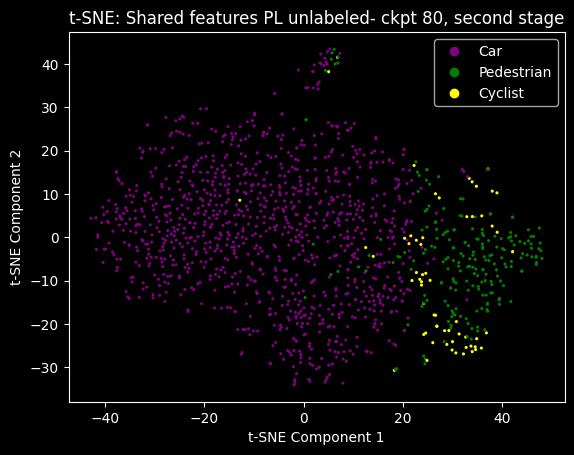

In [45]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# Create a sample dataset
x = sh_gt_array
y = pl_labels.astype(int)
iou_labels = iou_assigned_label

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)

# Create custom colormap
colors = ['purple', 'green', 'yellow']
cmap = ListedColormap(colors)

# Create a scatter plot with colored points based on labels
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap=cmap, s=1.5)

# Add legend
legend_labels = ['Car', 'Pedestrian', 'Cyclist']
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
title = "t-SNE: Shared features PL unlabeled- ckpt 80, second stage"
plt.title(title)

plt.show()


In [46]:
marker_dict = {0:"s",1:"o",2:"d"}
markers = [marker_dict[pl_labels[i]] for i in range(len(pl_labels))]


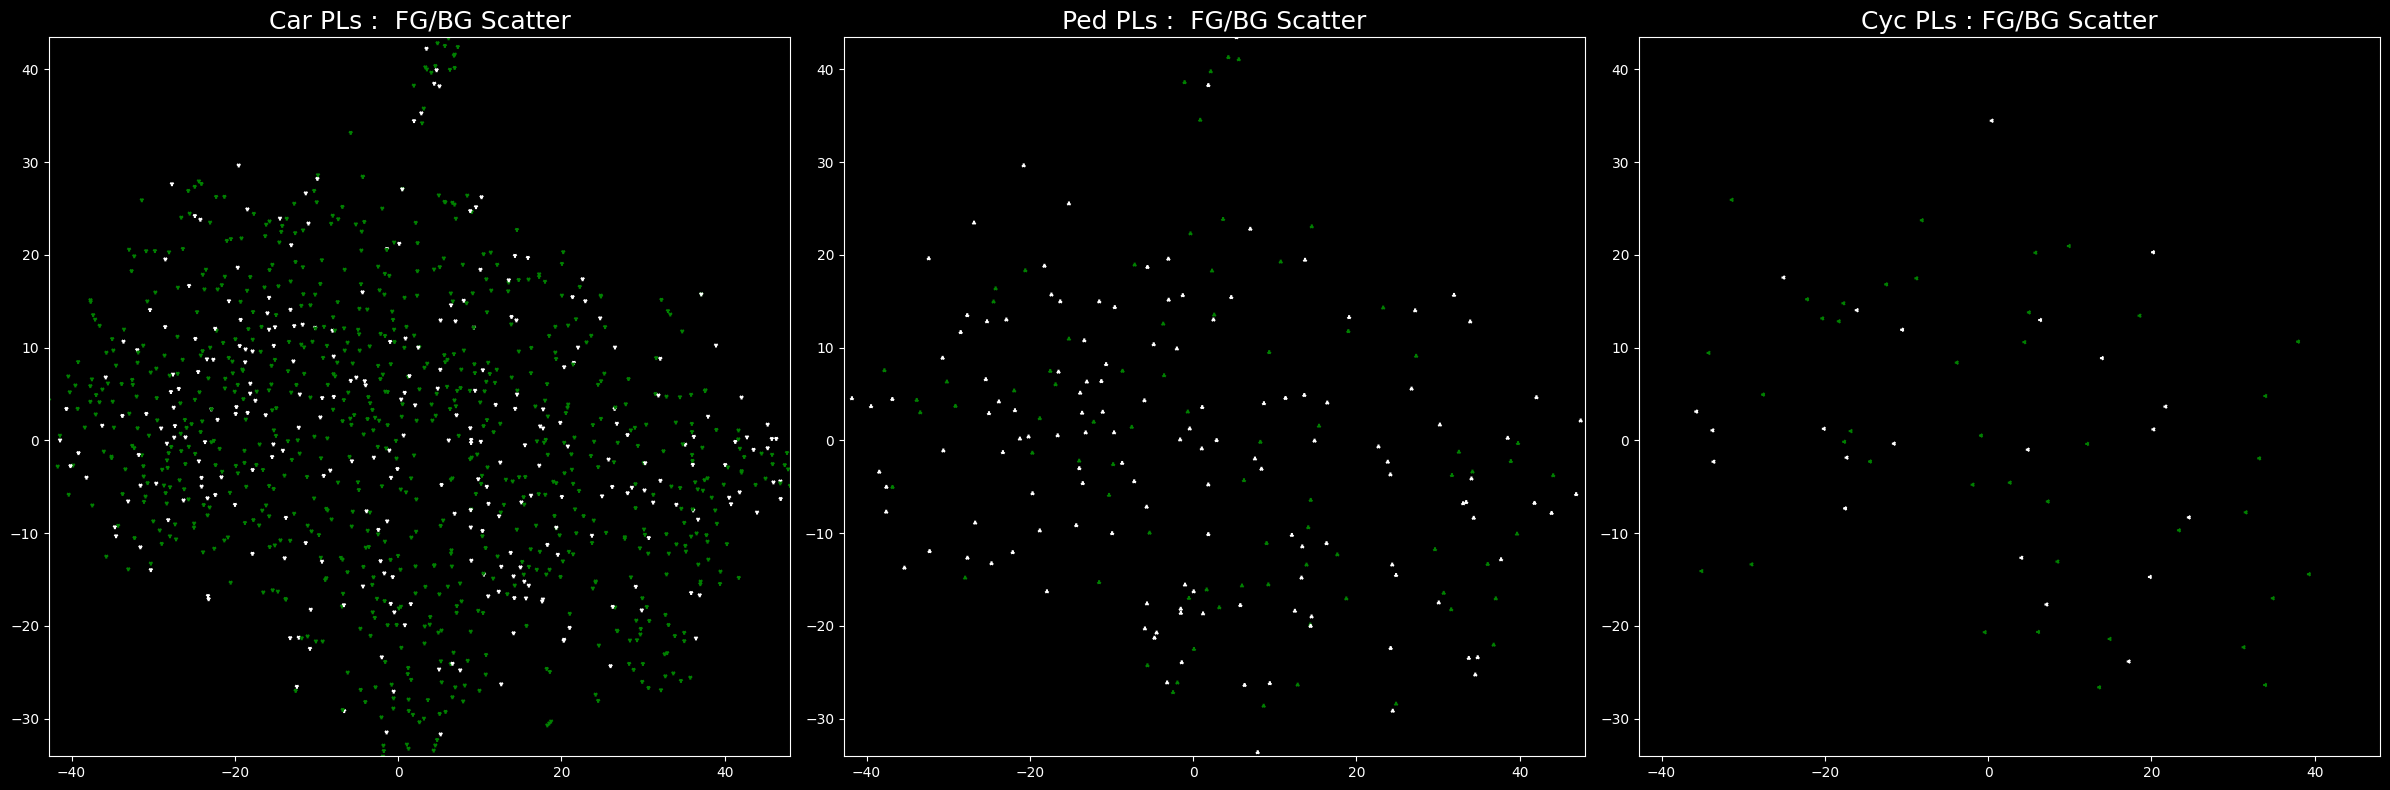

In [61]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
plt.style.use('dark_background')

# Create a sample dataset
x = sh_gt_array
y = pl_labels.astype(int)
conf_scores = iou_assigned_label
marker_dict = {0:"s",1:"o",2:"d"}
markers = [marker_dict[y[i]] for i in range(len(y))]
comparison_result = [-1 if score == -1 else (1 if label == score else 0) for label, score in zip(y, conf_scores)]
colors = ['white' if result == -1 else ('red' if result == 0 else 'green') for result in comparison_result]

# gt_iou_thresh = np.array([0.7, 0.5, 0.5])
# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)
# tsne_colors = get_objectness_tp_fp(x_tsne, y, conf_scores, gt_iou_thresh)

import numpy as np

# Get the indices that would sort y in ascending order
sorted_indices = np.argsort(y)
sorted_y = y[sorted_indices]
sorted_x_tsne = x_tsne[sorted_indices]
sorted_colors = [colors[i] for i in sorted_indices]
sorted_assigned_labels = [conf_scores[i] for i in sorted_indices]
idx_0_last = np.where(sorted_y == 0)[0][-1]
idx_1_first = np.where(sorted_y == 1)[0][0]
idx_1_last = np.where(sorted_y == 1)[0][-1]+1

x_min, x_max = min(x_tsne[:, 0]), max(x_tsne[:, 0])
y_min, y_max = min(x_tsne[:, 1]), max(x_tsne[:, 1])

# Plot t-SNE with markers and colors
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(24, 8))  # Create a figure with 3 subplots side by side
for ax in axs:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid(False)
# Plot the first scatter plot in the first subplot
axs[0].scatter(x_tsne[:idx_1_first, 0], x_tsne[:idx_1_first, 1], marker='1', color=sorted_colors[:idx_1_first], s=10)
axs[0].set_title('Car PLs :  FG/BG Scatter',fontsize = 18)

# Plot the second scatter plot in the second subplot
axs[1].scatter(x_tsne[idx_1_first:idx_1_last, 0], x_tsne[idx_1_first:idx_1_last, 1], marker='2', color=sorted_colors[idx_1_first:idx_1_last], s=10)
axs[1].set_title('Ped PLs :  FG/BG Scatter',fontsize = 18)

# Plot the third scatter plot in the third subplot
axs[2].scatter(x_tsne[idx_1_last:, 0], x_tsne[idx_1_last:, 1], marker='3', color=sorted_colors[idx_1_last:], s=10)
axs[2].set_title('Cyc PLs : FG/BG Scatter', fontsize = 18)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [56]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_precision_recall(sorted_y, sorted_assigned_labels, class_id):
    true_positives = np.sum((sorted_y == class_id) & (sorted_assigned_labels == 1))
    false_positives = np.sum((sorted_y != class_id) & (sorted_assigned_labels == 0))
    false_negatives = np.sum((sorted_y == class_id) & (sorted_assigned_labels == -1))

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    return precision, recall

comparison_result = np.array(comparison_result)
precision_car, recall_car = calculate_precision_recall(sorted_y, comparison_result, class_id=0)
precision_pedestrian, recall_pedestrian = calculate_precision_recall(sorted_y, comparison_result, class_id=1)
precision_cyclist, recall_cyclist = calculate_precision_recall(sorted_y, comparison_result, class_id=2)

print("Precision and Recall for Car class:")
print("Precision:", precision_car)
print("Recall:", recall_car)

print("\nPrecision and Recall for Pedestrian class:")
print("Precision:", precision_pedestrian)
print("Recall:", recall_pedestrian)

print("\nPrecision and Recall for Cyclist class:")
print("Precision:", precision_cyclist)
print("Recall:", recall_cyclist)


# plt.figure(figsize=(8, 6))
# plt.plot(recall_car, precision_car, marker='o', linestyle='-', label='Car')
# plt.plot(recall_pedestrian, precision_pedestrian, marker='o', linestyle='-', label='Pedestrian')
# plt.plot(recall_cyclist, precision_cyclist, marker='o', linestyle='-', label='Cyclist')

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend()
# plt.grid(True)
# plt.show()


Precision and Recall for Car class:
Precision: 1.0
Recall: 0.6714015151515151

Precision and Recall for Pedestrian class:
Precision: 1.0
Recall: 0.6952380952380952

Precision and Recall for Cyclist class:
Precision: 1.0
Recall: 0.6290322580645161


In [63]:
import os
import pickle
# Directory containing the pickle files
pickle_dir = "/mnt/data/adat01/adv_OpenPCDet/output/cfgs/kitti_models/pv_rcnn_ssl_60/exp1_batch_dict_new_30_4f0683d"
# List all pickle files in the directory
pickle_files = [file for file in os.listdir(pickle_dir) if file.endswith(".pkl")]

# Initialize an empty dictionary to store aggregated data
snapshot_pl_data_20 = {}

# Iterate over each pickle file
for file in pickle_files:
    # Load the pickle file
    with open(os.path.join(pickle_dir, file), "rb") as f:
        data = pickle.load(f)
    # Combine the data from the current file with the aggregated data
    for key, value in data.items():
        if key not in snapshot_pl_data_20:
            snapshot_pl_data_20[key] = []
        snapshot_pl_data_20[key].extend(value)



In [68]:
sh_gt_array = np.concatenate(snapshot_pl_data_20['shared_features_gt'])
sh_gt_array.shape
pl_labels = np.concatenate(snapshot_pl_data_20['pl_boxes'])
pl_labels = pl_labels[:, -1]
pl_labels.shape
for i in range(len(snapshot_pl_data_20['iou_assigned_label'])):
    snapshot_pl_data_20['iou_assigned_label'][i] = snapshot_pl_data_20['iou_assigned_label'][i].cpu()

iou_assigned_label = np.concatenate(snapshot_pl_data_20['iou_assigned_label'])
iou_assigned_label.shape
pl_boxes = np.concatenate(snapshot_pl_data_20['pl_boxes']) #6091,8
gt_boxes = np.concatenate(snapshot_pl_data_20['ori_gt_boxes'])  #9523,8
frames =  np.array(snapshot_pl_data_20['frame_id'])
np.unique(frames).shape
print(pl_boxes.shape, gt_boxes.shape)
print(np.unique(frames).shape)


(14094, 8) (16516, 8)
(2213,)


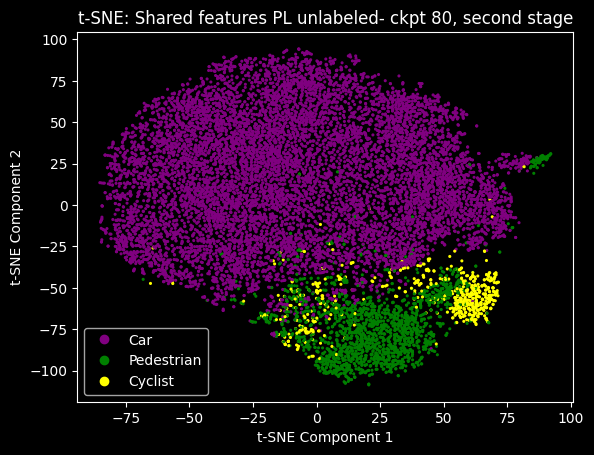

In [66]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# Create a sample dataset
x = sh_gt_array
y = pl_labels.astype(int)
iou_labels = iou_assigned_label

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)

# Create custom colormap
colors = ['purple', 'green', 'yellow']
cmap = ListedColormap(colors)

# Create a scatter plot with colored points based on labels
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap=cmap, s=1.5)

# Add legend
legend_labels = ['Car', 'Pedestrian', 'Cyclist']
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
title = "t-SNE: Shared features PL unlabeled- ckpt 80, second stage"
plt.title(title)

plt.show()


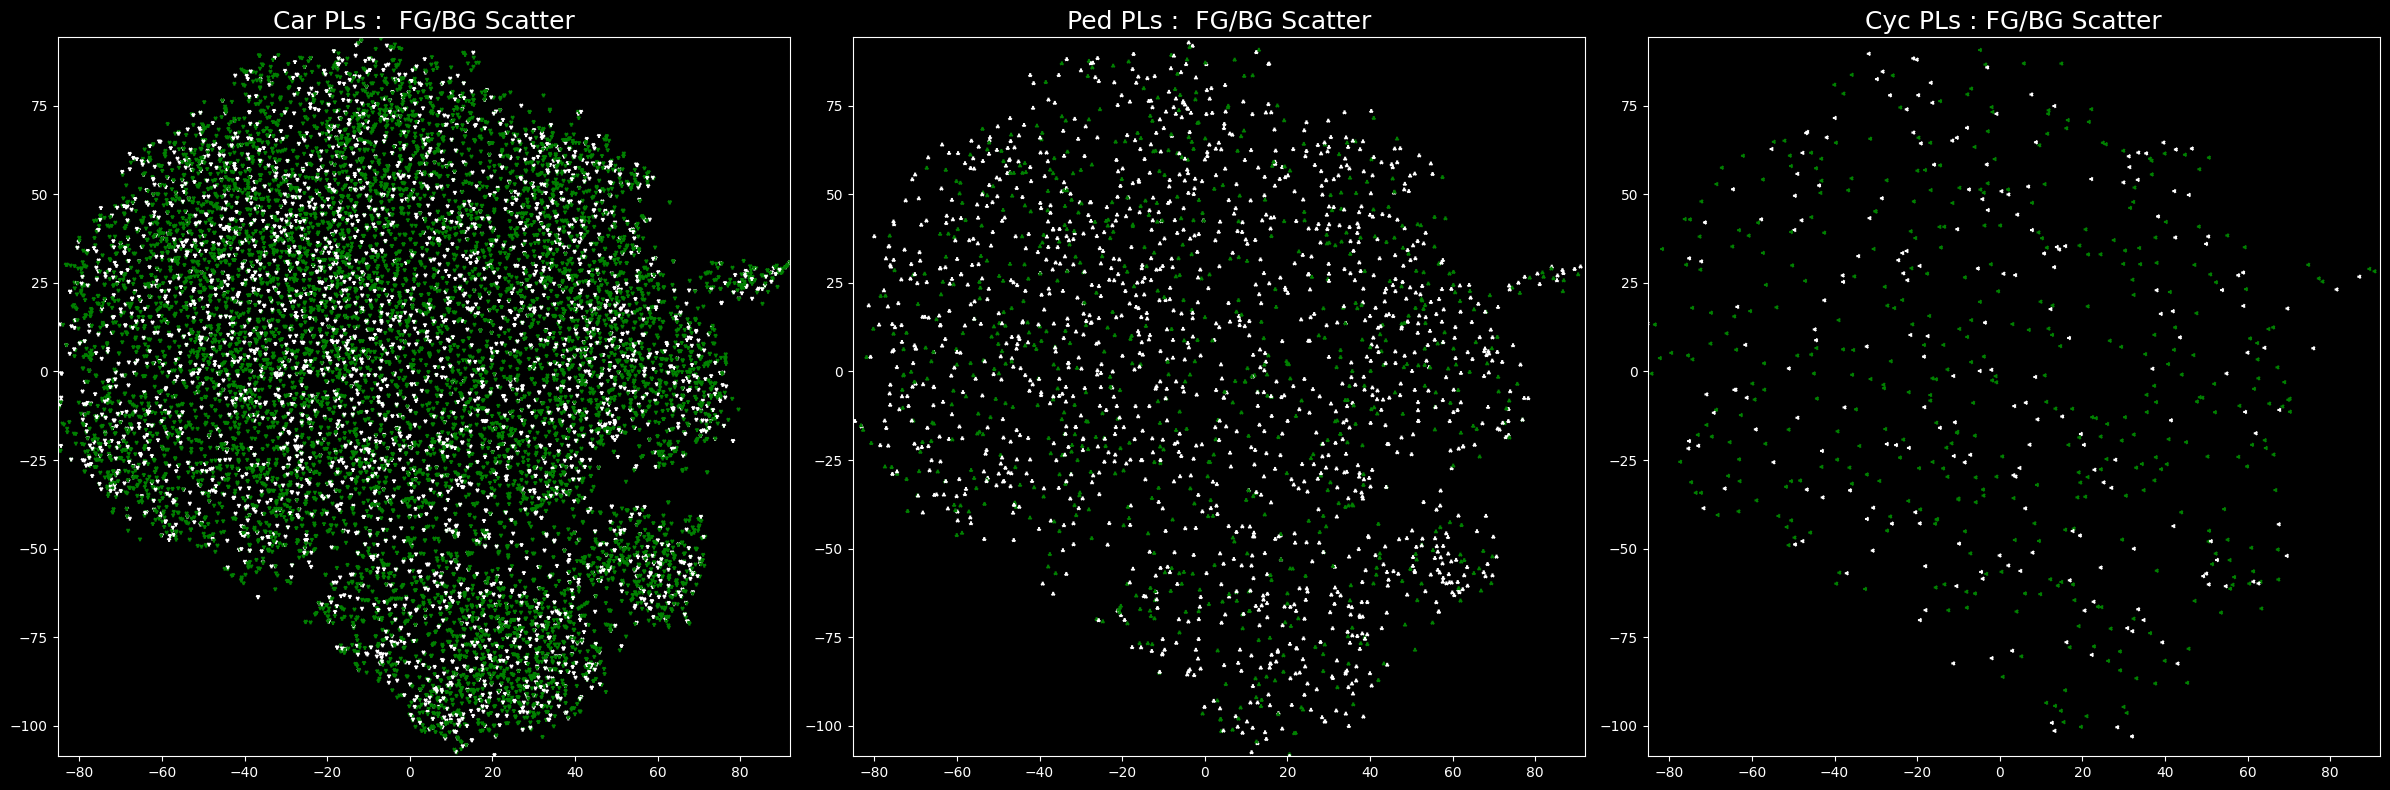

In [69]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
plt.style.use('dark_background')

# Create a sample dataset
x = sh_gt_array
y = pl_labels.astype(int)
conf_scores = iou_assigned_label
marker_dict = {0:"s",1:"o",2:"d"}
markers = [marker_dict[y[i]] for i in range(len(y))]
comparison_result = [-1 if score == -1 else (1 if label == score else 0) for label, score in zip(y, conf_scores)]
colors = ['white' if result == -1 else ('red' if result == 0 else 'green') for result in comparison_result]

# gt_iou_thresh = np.array([0.7, 0.5, 0.5])
# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)
# tsne_colors = get_objectness_tp_fp(x_tsne, y, conf_scores, gt_iou_thresh)

import numpy as np

# Get the indices that would sort y in ascending order
sorted_indices = np.argsort(y)
sorted_y = y[sorted_indices]
sorted_x_tsne = x_tsne[sorted_indices]
sorted_colors = [colors[i] for i in sorted_indices]
sorted_assigned_labels = [conf_scores[i] for i in sorted_indices]
idx_0_last = np.where(sorted_y == 0)[0][-1]
idx_1_first = np.where(sorted_y == 1)[0][0]
idx_1_last = np.where(sorted_y == 1)[0][-1]+1

x_min, x_max = min(x_tsne[:, 0]), max(x_tsne[:, 0])
y_min, y_max = min(x_tsne[:, 1]), max(x_tsne[:, 1])

# Plot t-SNE with markers and colors
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(24, 8))  # Create a figure with 3 subplots side by side
for ax in axs:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid(False)
# Plot the first scatter plot in the first subplot
axs[0].scatter(x_tsne[:idx_1_first, 0], x_tsne[:idx_1_first, 1], marker='1', color=sorted_colors[:idx_1_first], s=10)
axs[0].set_title('Car PLs :  FG/BG Scatter',fontsize = 18)

# Plot the second scatter plot in the second subplot
axs[1].scatter(x_tsne[idx_1_first:idx_1_last, 0], x_tsne[idx_1_first:idx_1_last, 1], marker='2', color=sorted_colors[idx_1_first:idx_1_last], s=10)
axs[1].set_title('Ped PLs :  FG/BG Scatter',fontsize = 18)

# Plot the third scatter plot in the third subplot
axs[2].scatter(x_tsne[idx_1_last:, 0], x_tsne[idx_1_last:, 1], marker='3', color=sorted_colors[idx_1_last:], s=10)
axs[2].set_title('Cyc PLs : FG/BG Scatter', fontsize = 18)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [70]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_precision_recall(sorted_y, sorted_assigned_labels, class_id):
    true_positives = np.sum((sorted_y == class_id) & (sorted_assigned_labels == 1))
    false_positives = np.sum((sorted_y != class_id) & (sorted_assigned_labels == 0))
    false_negatives = np.sum((sorted_y == class_id) & (sorted_assigned_labels == -1))

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    return precision, recall

comparison_result = np.array(comparison_result)
precision_car, recall_car = calculate_precision_recall(sorted_y, comparison_result, class_id=0)
precision_pedestrian, recall_pedestrian = calculate_precision_recall(sorted_y, comparison_result, class_id=1)
precision_cyclist, recall_cyclist = calculate_precision_recall(sorted_y, comparison_result, class_id=2)

print("Precision and Recall for Car class:")
print("Precision:", precision_car)
print("Recall:", recall_car)

print("\nPrecision and Recall for Pedestrian class:")
print("Precision:", precision_pedestrian)
print("Recall:", recall_pedestrian)

print("\nPrecision and Recall for Cyclist class:")
print("Precision:", precision_cyclist)
print("Recall:", recall_cyclist)


# plt.figure(figsize=(8, 6))
# plt.plot(recall_car, precision_car, marker='o', linestyle='-', label='Car')
# plt.plot(recall_pedestrian, precision_pedestrian, marker='o', linestyle='-', label='Pedestrian')
# plt.plot(recall_cyclist, precision_cyclist, marker='o', linestyle='-', label='Cyclist')

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend()
# plt.grid(True)
# plt.show()


Precision and Recall for Car class:
Precision: 1.0
Recall: 0.6593878803823555

Precision and Recall for Pedestrian class:
Precision: 1.0
Recall: 0.6682808716707022

Precision and Recall for Cyclist class:
Precision: 1.0
Recall: 0.670926517571885
